Try to perform Person Identification using a SimCLR architecture with a **ResNet18** as encoder.

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader#, #Dataset, 

#from copy import deepcopy
from sklearn.metrics import confusion_matrix
from utils_preprocess import *
from utils_traintest import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, ZeroPad2d, CrossEntropyLoss
from torch.optim import SGD, Adam, AdamW, lr_scheduler
#import torchvision
from tqdm import tqdm

# import the models
from models.ResNet18 import ResNet18

In [2]:
# Set seeds for reproducibility
# fix this
seed = 203345656
torch.manual_seed(seed)

In [3]:
read_path = "./models/ResNet18"
create_subfolders_from_ckpt(read_path)

Subfolder already exists: ./models/ResNet18/My_ResNet18_hd16_bs512
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd64_bs256_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd64_bs512_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd256_bs256_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd32_bs512_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd32_bs256_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd64_bs128
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd128_bs128_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd16_bs128
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd32_bs128
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd16_bs256_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd256_bs128_200ep
Subfolder already exists: ./models/ResNet18/My_ResNet18_hd128_bs256_200ep


In [4]:
activities_considered = 'E,L,W,R,J'

### Step 1
#### Class definition and training for encoder 
**This can be either done with self-supervised contrastive, or with supervised contrastive**\
In pratica questa sezione andrà eliminata, perchè carichiamo i modelli già allenati dal buon Fede

In [9]:
class Conv2d_rl(Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding)
        self.relu = nn.ReLU()

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        return self.relu(x)
    
class Reduction(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=2, stride=2, padding=0) #170,50
        self.central_block = Conv2d_rl(in_filters=in_filters, out_filters=5, kernel_size=2, strides=2, padding="valid")
        self.right_block =  Sequential(
            Conv2d_rl(in_filters=in_filters, out_filters=3, kernel_size=1, strides=1, padding="same"), 
            Conv2d_rl(in_filters=3, out_filters=6, kernel_size=2, strides=1, padding="same"),  
            Conv2d_rl(in_filters=6, out_filters=9, kernel_size=4, strides=2, padding=1),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x
    
class Inception(Module):

    def __init__(self):
        super().__init__()
        self.reductions = Sequential(Reduction(1))
        self.conv = Conv2d_rl(in_filters=15, out_filters=3, kernel_size=1, strides=1, padding="same") # here pad doesnt make much difference
        self.drop = Dropout(0.2)
        self.classification_layer = Linear(25500, 5) #170*50*3 / 10
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.reductions(x)
        x = self.conv(x)
        x = t.flatten(x, start_dim=1) 
        #x = x.reshape(x.shape[0], -1, 2550).mean(axis=1)
        x = self.drop(x)
        y = self.classification_layer(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


# TODO: modify the architecture to have a hidden_dimension argument?
class InceptionDouble(Module):

    def __init__(self):
        super().__init__()
        self.reductions = Sequential(Reduction(1),
                                     Reduction(15)) # 85*25
        self.conv = Conv2d_rl(in_filters=29, out_filters=3, kernel_size=1, strides=1, padding="same")
        self.avg = nn.AvgPool2d(kernel_size=2, stride=2)
        #self.drop = Dropout(0.2)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.reductions(x)
        x = self.conv(x)
        x = self.avg(x)
        x = t.flatten(x, start_dim=1)
        #x = self.drop(x)
        return x

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [5]:
class SimCLR(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()

        # Base model f(.)
        self.encoder = InceptionDouble() # 6375 o 1512 credo dopo l'avg pooling

        # projection head g(.)
        self.classification_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1512, 4*hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)
        project = self.classification_layer(feats)
        return project
    

# this should be the correct way to train the encoder + a projection head
# IT IS MANDATORY to modify the classification_layer of the ResNet18 (if there is any, after the network)
# otherwise when we call self.encoder(x) we will call the "old" one in the ResNet class
# (for comparison see the colab example)

class SimCLR18(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Base model f(.)
        self.encoder = ResNet18(hidden_dim)

        # projection head g(.): modify the ResNet18 attribute
        # so that we dont need to modify the ResNet18 forward method
        self.encoder.classification_layer = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(512, 4*hidden_dim),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)
        return feats

In [6]:
test_new = SimCLR18(64)
print(test_new)

SimCLR18(
  (encoder): ResNet18(
    (network): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=valid)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ConvolutionalBlock(
        (main_path): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
        (shortcut_path): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
     

##### 1.1 Self-supervised contrastive learning

In [7]:
dir_init = './doppler_traces/' 
subdirs_init = 'S1a,S1b,S1c' 
transforms = DopplerTransformations()

dataset_csi_self_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)
dataset_csi_self_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)
dataset_csi_self_test, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)

In [8]:
print(labels_true_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [9]:
# Define training hyperparameters
batch_size=128
hidden_dim=128
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100

#path to the folder where pretrained models are saved
CHECKPOINT_PATH = "./saved_models"


# Define SimCLR Model
simclr_model = SimCLR18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
my_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive_self(simclr_model, device, dataset_csi_self_train, optimizer, my_lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_accs.append(train_top1_acc)

    # Validation iterations
    val_loss, val_top1_acc = valid_constrastive_self(simclr_model, device, dataset_csi_self_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_accs.append(val_top1_acc)

    if epoch%10 == 0:
        # Save the model
        torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'SimCLR_ResNet18_self.ckpt'))
        # saves the curves
        csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics.csv')
        # Write the lists to a CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
            writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])
        
        print(f"Training metrics saved to {csv_file_path}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2560 and 512x512)

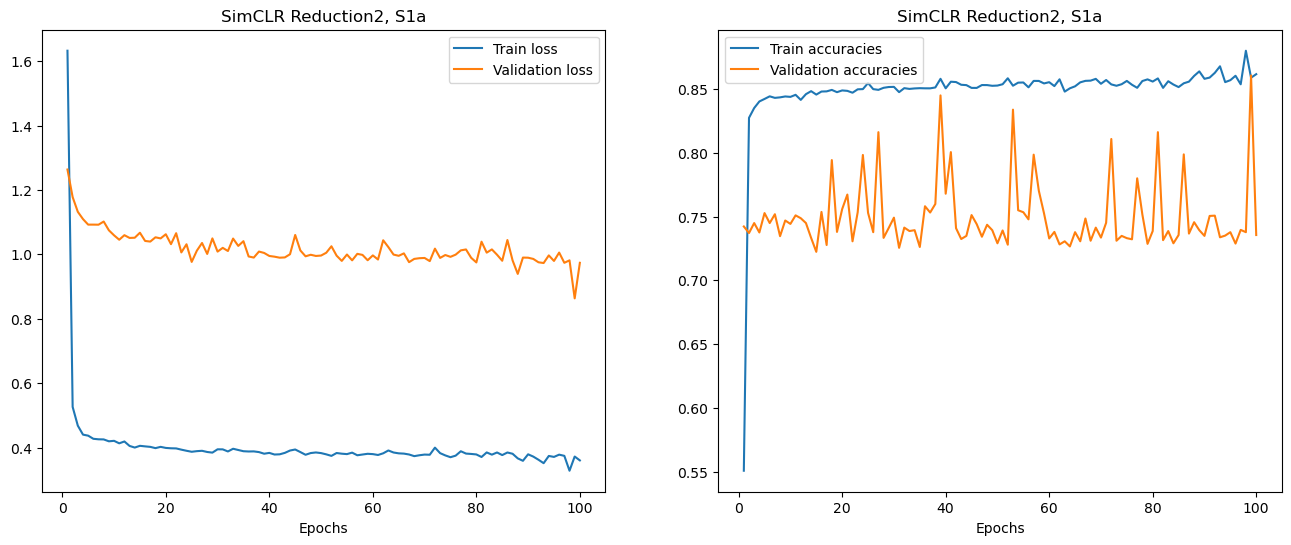

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("SimCLR Reduction2, S1a")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("SimCLR Reduction2, S1a")
ax2.legend()

##### 1.2 Supervised contrastive learning 

In [7]:
dir_init = './doppler_traces/' 
subdirs_init = 'S1a,S1b,S1c' 

dataset_csi_sup_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True)
dataset_csi_sup_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True)
dataset_csi_sup_test, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, aggregate=True)

In [8]:
# Define training hyperparameters
batch_size=64
hidden_dim=64
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100

#path to the folder where pretrained models are saved
CHECKPOINT_PATH = "./saved_models"


# Define SimCLR Model
simclr_model = SimCLR18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
my_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive_sup(simclr_model, device, dataset_csi_sup_train, optimizer, my_lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_accs.append(train_top1_acc)

    # Validation iterations
    val_loss, val_top1_acc = valid_constrastive_sup(simclr_model, device, dataset_csi_sup_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_accs.append(val_top1_acc)

    if epoch%10 == 0:
        # Save the model
        torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'SimCLR_ResNet18_sup.ckpt'))
        # saves the curves
        csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics.csv')
        # Write the lists to a CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
            writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])
        
        print(f"Training metrics saved to {csv_file_path}")

Train Epoch: 0,  	Loss: 4.840105, 	Top1_Acc: 0.000000
Valid Epoch: 0,  	Loss: 4.771541, 	Top1_Acc: 0.004762


IndexError: list index out of range

In [18]:
epoch = 0
# Save the model
torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'SimCLR_ResNet18_sup.ckpt'))
# saves the curves
csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics.csv')
# Write the lists to a CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
    writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])

print(f"Training metrics saved to {csv_file_path}")

Training metrics saved to ./saved_models/training_metrics.csv


In [16]:
epoch

1

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("Supervised SimCLR ResNet18, S1all")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("Supervised SimCLR ResNet18, S1all")
ax2.legend()

### Step 2

#### 2.1.1 
#### Train & Test the 1st classifier
Remove the classification layer from the encoder model and append a projection head for HAR classification tasks.\
We test different classifiers with either one or two layers.

In [5]:
class SimpleClassifierOneLayer(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierOneLayer'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.model(x)
    
class SimpleClassifierTwoLayersRes(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierTwoLayersRes'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    
class SimpleClassifierTwoLayers(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.name = 'SimpleClassifierTwoLayers'

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            #nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Save the encoder
#torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_SimCLR.ckpt'))
simclr_model = ResNet18(hidden_dimension=128)

# Load the trained encoder here
path_model = 'models/ResNet18/My_ResNet18_hd128_bs128.ckpt'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))
save_dir = 'models/ResNet18/My_ResNet18_hd128_bs128'


<All keys matched successfully>

In [7]:
# encode the input data (train, test & validation) with the trained representation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init)

train_feats = prepare_data_features(simclr_model, dataset_csi_train_class, device=device)
val_feats = prepare_data_features(simclr_model, dataset_csi_val_class, device=device)

100%|██████████| 210/210 [01:36<00:00,  2.17it/s]


In [8]:
feats, labels = train_feats.tensors  # Accedi ai tensori contenuti nel TensorDataset
print(feats.shape)
print(labels.shape)

torch.Size([21648, 2560])
torch.Size([21648, 1])


#### From here on to train the projection heads \
#### Remember to change the name

In [9]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

batch_size=64
num_classes=5
lr=1e-3
weight_decay=1e-3
epochs=50
har_projection_head = SimpleClassifierTwoLayersRes(2560, num_classes=5)
opt = AdamW(har_projection_head.parameters(), lr=lr, weight_decay=weight_decay)
save_name_proj = har_projection_head.name+'_HAR'+'_'+activities_considered

train_losses, train_accs, val_losses, val_accs = train_projection(model=har_projection_head, optimizer=opt, train_feats_data=train_feats, val_feats_data=val_feats, save_dir=save_dir, save_name=save_name_proj+'.ckpt', device="cpu", batch_size=batch_size, epochs=epochs)

Epoch: 0, Train Loss: 0.739944, Train Accuracy: 0.632190
Epoch: 0, Val Loss: 0.640433, Val Accuracy: 0.676108
Saved Model
Epoch: 1, Train Loss: 0.604434, Train Accuracy: 0.693077
Epoch: 1, Val Loss: 0.656783, Val Accuracy: 0.684408
Epoch: 2, Train Loss: 0.571167, Train Accuracy: 0.713219
Epoch: 2, Val Loss: 0.593355, Val Accuracy: 0.689302
Saved Model
Epoch: 3, Train Loss: 0.547159, Train Accuracy: 0.725018
Epoch: 3, Val Loss: 0.663705, Val Accuracy: 0.668981
Epoch: 4, Train Loss: 0.524687, Train Accuracy: 0.737601
Epoch: 4, Val Loss: 0.677595, Val Accuracy: 0.678373
Epoch: 5, Train Loss: 0.504689, Train Accuracy: 0.749263
Epoch: 5, Val Loss: 0.576791, Val Accuracy: 0.702034
Saved Model
Epoch: 6, Train Loss: 0.478801, Train Accuracy: 0.761707
Epoch: 6, Val Loss: 0.629987, Val Accuracy: 0.699851
Epoch: 7, Train Loss: 0.467414, Train Accuracy: 0.771801
Epoch: 7, Val Loss: 0.596262, Val Accuracy: 0.704315
Epoch: 8, Train Loss: 0.449872, Train Accuracy: 0.780927
Epoch: 8, Val Loss: 0.61118

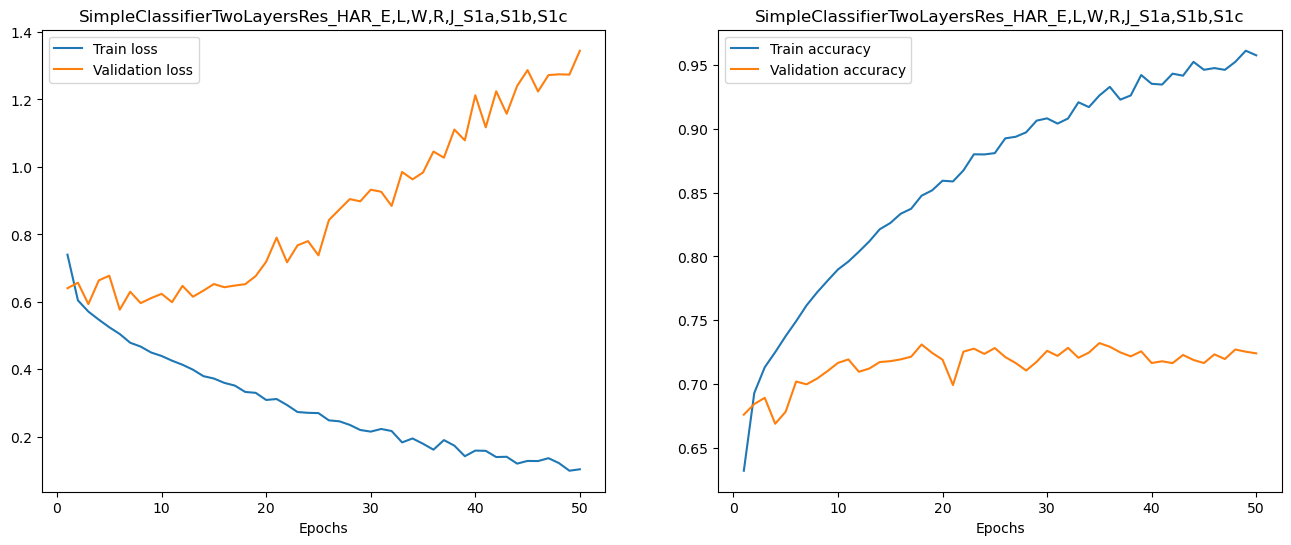

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, epochs+1), train_losses, label="Train loss")
ax1.plot(np.arange(1, epochs+1), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
#ax1.set_title("SimpleClassifier_HAR_hd16_bs128, S1a")
ax1.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax1.legend()
ax2.plot(np.arange(1,epochs+1), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,epochs+1), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax2.legend()

In [11]:
### TEST ###

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

dataset_csi_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)
test_feats = prepare_data_features(simclr_model, dataset_csi_test_class, device=device)

labels_considered = np.arange(5)

100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


In [12]:
# define a classifier object
classifier_model = har_projection_head

# Load the trained projection head here
path_model = save_dir+'/'+save_name_proj+'.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [13]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 103/103 [00:00<00:00, 907.60it/s]

shape of the predicted labels list: torch.Size([6544, 5])
shape of the true labels: torch.Size([6544])
loss: 0.6524020433425903, accuracy: 0.7131723761558533


/home/giovanni/Desktop/Deep Learning/project/NNDL HAR project/utils_traintest.py:456: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
/home/giovanni/miniconda3/envs/dlproject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


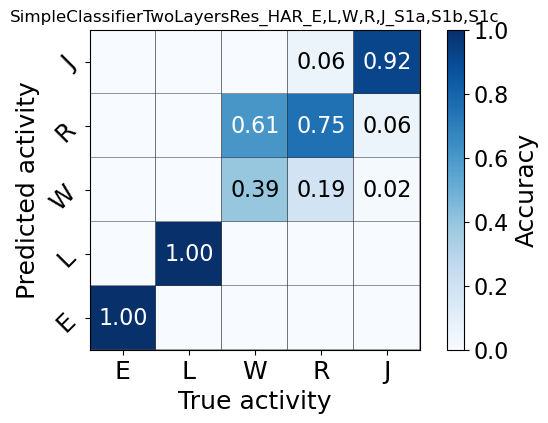

In [14]:
### Merge the predictions from the various antennas ###

labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)
activities = np.array(['E','L','W','R','J'])
plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, lables=activities, title=str(save_name_proj)+'_'+str(subdirs_init), save_dir=save_dir, save_name=save_name_proj)

### 2.2
#### Train & Test the 2nd classifier

Now we train the second projection head, used for person identification.\
Our dataset has 3 different "people" features. We need to labels data according to the person it refers to, and then to train the projection head on these.\
The dataset are divided as follows: 
- S1, S2, S4, S6 -> P1
- S3, S5 -> P2
- S7 -> P3

***REMEBER TO CHANGE THE NUMBER OF OUTPUT CLASSES!***


In [15]:
simclr_model = ResNet18(hidden_dimension=128)
path_model = 'models/ResNet18/My_ResNet18_hd128_bs128.ckpt'
save_dir = 'models/ResNet18/My_ResNet18_hd128_bs128'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [16]:
# encode the input data (train, test & validation) with the trained representation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S3a,S7a' #Subdirs for training
n_people = 3

dataset_PI_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)
dataset_PI_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)

train_feats_PI = prepare_data_features(simclr_model, dataset_PI_train_class, device=device)
val_feats_PI = prepare_data_features(simclr_model, dataset_PI_val_class, device=device)

100%|██████████| 204/204 [01:43<00:00,  1.96it/s]


In [17]:
batch_size=64
num_classes=n_people
lr=1e-3
weight_decay=1e-3
epochs = 100
pi_projection_head = SimpleClassifierTwoLayersRes(2560, num_classes=n_people) # use the same model as for HAR
opt = AdamW(pi_projection_head.parameters(), lr=lr, weight_decay=weight_decay)
save_name_proj = pi_projection_head.name+'_PI'+'_'+activities_considered

train_losses_PI, train_accs_PI, val_losses_PI, val_accs_PI = train_projection(model=pi_projection_head, optimizer=opt, train_feats_data=train_feats_PI, val_feats_data=val_feats_PI, save_dir=save_dir, save_name=save_name_proj+'.ckpt', device="cpu", batch_size=batch_size, epochs=epochs)

Epoch: 0, Train Loss: 1.100083, Train Accuracy: 0.383031
Epoch: 0, Val Loss: 1.041886, Val Accuracy: 0.435285
Saved Model
Epoch: 1, Train Loss: 1.035237, Train Accuracy: 0.434360
Epoch: 1, Val Loss: 1.010133, Val Accuracy: 0.440458
Saved Model
Epoch: 2, Train Loss: 1.006191, Train Accuracy: 0.458019
Epoch: 2, Val Loss: 0.990309, Val Accuracy: 0.466358
Saved Model
Epoch: 3, Train Loss: 0.979846, Train Accuracy: 0.488620
Epoch: 3, Val Loss: 0.977020, Val Accuracy: 0.476822
Saved Model
Epoch: 4, Train Loss: 0.956574, Train Accuracy: 0.503057
Epoch: 4, Val Loss: 0.978694, Val Accuracy: 0.478365
Epoch: 5, Train Loss: 0.940464, Train Accuracy: 0.521032
Epoch: 5, Val Loss: 0.944765, Val Accuracy: 0.515601
Saved Model
Epoch: 6, Train Loss: 0.921131, Train Accuracy: 0.533011
Epoch: 6, Val Loss: 0.937510, Val Accuracy: 0.524345
Saved Model
Epoch: 7, Train Loss: 0.915810, Train Accuracy: 0.537159
Epoch: 7, Val Loss: 0.950521, Val Accuracy: 0.493366
Epoch: 8, Train Loss: 0.891824, Train Accuracy: 

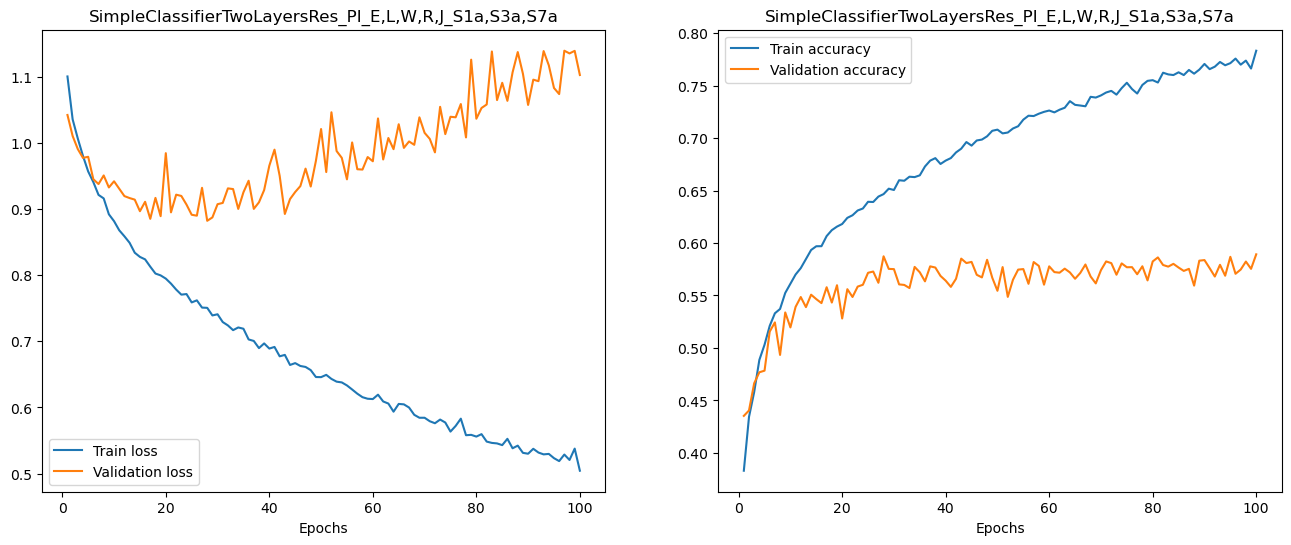

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, epochs+1), train_losses_PI, label="Train loss")
ax1.plot(np.arange(1, epochs+1), val_losses_PI, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax1.legend()
ax2.plot(np.arange(1,epochs+1), train_accs_PI, label="Train accuracy")
ax2.plot(np.arange(1,epochs+1), val_accs_PI, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title(str(save_name_proj)+'_'+str(subdirs_init))
ax2.legend()

In [19]:
### TEST ###

#dir_init = './doppler_traces/' #Directory of data
#subdirs_init = 'S1a,S3a,S7a'

dataset_csi_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, activities_init=activities_considered, PI=n_people)
test_feats = prepare_data_features(simclr_model, dataset_csi_test_class, device=device)

labels_considered = np.arange(3)

100%|██████████| 199/199 [01:43<00:00,  1.93it/s]


In [20]:
classifier_model = pi_projection_head

# Load the trained projection head here
path_model = save_dir+'/'+save_name_proj+'.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [21]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true)
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 100/100 [00:00<00:00, 602.99it/s]

shape of the predicted labels list: torch.Size([6352, 3])
shape of the true labels: torch.Size([6352])
loss: 0.9204894304275513, accuracy: 0.5640742778778076


/home/giovanni/Desktop/Deep Learning/project/NNDL HAR project/utils_traintest.py:456: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
/home/giovanni/miniconda3/envs/dlproject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


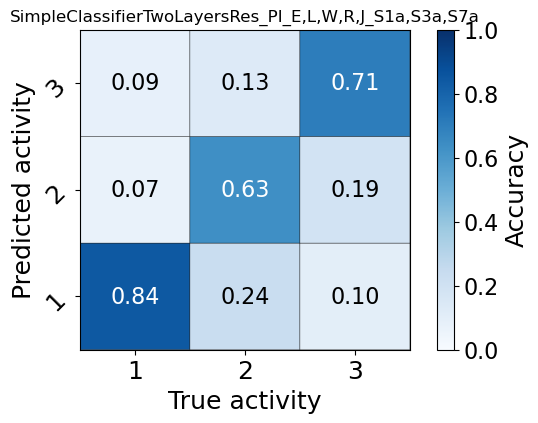

In [22]:
labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)
conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)
people = np.array(['1','2','3'])
plt_confusion_matrix(people.shape[0], conf_matrix_max_merged, lables=people, title=str(save_name_proj)+'_'+str(subdirs_init), save_dir=save_dir, save_name=save_name_proj)